# Initialisation & Setup

### Importing core libraries necessary for the case study

In [ ]:
# Importing the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Using Seaborn's aesthetic theme
sns.set_theme()

### Loading Data from CSV file

In [ ]:
raw_loans = pd.read_csv('loan.csv', dtype={47:str}, low_memory=False)

# number of rows and columns
print("Number of rows: ", len(raw_loans))
print("Number of Columns: ", len(raw_loans.columns))

raw_loans.head()

# Data Cleaning & Manipulation

## Fixing Rows & Columns

### Row Clean Up
> Removing loans that are still in progress ( 'loan_status' = 'Current' )

In [ ]:
loans = raw_loans[raw_loans['loan_status'] != 'Current']
loans.shape

### Columns Clean Up 

#### Checking columns with NA or Null values

In [ ]:
loans.columns[loans.isna().all()]

In [ ]:
print(len(loans.columns[loans.isna().all()]), "columns have NA values in all rows, these columns can be dropped")

##### Dropping columns with all NA or Null values

In [ ]:
loans = loans.dropna(axis=1, how='all')

# Left with columns data
print("Columns left: ", len(loans.columns))

#### Checking columns with constant values

In [ ]:
loans.columns[loans.nunique() == 1]

In [ ]:
unique_value_cols = loans.columns[loans.nunique() == 1]

print(len(unique_value_cols), "columns have only one unique value, these columns can be dropped as they do not provide any useful information")

##### Dropping columns with all same values

In [ ]:
loans = loans.drop(unique_value_cols, axis=1)

# Left with columns data
print("Columns left: ", len(loans.columns))

### Dropping Columns

In [ ]:
loans.info()

In [ ]:
loans.head()

In [ ]:
for column in loans.columns:
    unique_count = loans[column].nunique()
    print(f"{column} : {unique_count}")

#### Now we have 45 columns out of which we have some columns not useful for the analysis
Columns such as 
- 'desc', 'title', doesn't contribute to loan defaulting in any way. So excluding them from analysis.
- 'id', 'member_id' consists of unique values, which means we don't have multiple loan applications for the same person. Since both pair of values in the columns represent the same person. So we can use any one of the column as an index. Hence dropping the later.
- 'emp_title' has 28,027 unique values out of 38,577 total values. So it doesn't contribute usefully to the analysis. So dropping that.
- 'mths_since_last_delinq', 'mnths_since_last_record' has >60% missing values, so dropping them.
- 'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d', 'recoveries', 'revol_bal', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_credit_pull_d', 'earliest_cr_line' refer to behavoural data of a customer post loan approval. The data is not available at the time of loan approval and thus cannot be used for analysis. Hence the said columns are dropped.
- 'funded_amnt_inv', 'total_pymnt_inv' is useful for investors but doesn't contribute for analysing loan defaulter , so droping them.
- 'url' is a static link with id as the attribute. It's a redundant column. Hence dropping that
- Among 'zip_code', 'addr_state' any one of them can be used for analysis based on location, so dropping the former.

In [ ]:
loans = loans.drop(['member_id', 'url', 'desc', 'title', 'emp_title', 
                    'zip_code', 'mths_since_last_delinq', 'mths_since_last_record', 
                    'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d', 
                    'recoveries', 'revol_bal', 'total_rec_prncp', 'total_rec_int', 
                    'total_rec_late_fee', 'last_credit_pull_d', 'earliest_cr_line', 
                    'funded_amnt_inv', 'total_pymnt_inv'], axis=1)
loans.head()

In [ ]:
loans.shape

In [ ]:
loans.columns

### Checking for missing values

In [ ]:
missing = (loans.isna().sum()/len(loans.index))*100
missing[missing>0]

In [ ]:
missing = loans.isna().sum()
missing[missing>0]

In [ ]:
loans['emp_length'].value_counts()

#### Handling Missing Values
> Columns with missing values are 'emp_length', 'revol_util', 'pub_rec_bankruptcies' .
<br>
> Let's see what type of data each column has

In [ ]:
loans[['emp_length', 'revol_util', 'pub_rec_bankruptcies']].info()

##### 'emp_length' :

In [ ]:
print("Mode : ", loans['emp_length'].mode()[0])
loans['emp_length'].value_counts()

> The above value counts shows that the mode value has higher frequency than that of the next most frequent value.
<br>
<br>
> Since the missing values are in a very low percentage, imputing the missing values with the mode of the existing 'emp_length' values doesn't effect the analysis much, given the nature of the missing data.
<br>
> Hence assigning the mode to the null values in the column 'emp_length'

In [ ]:
loans['emp_length'].fillna(loans['emp_length'].mode()[0], inplace = True)
loans['emp_length'].isna().sum()

In [ ]:
missing = (loans.isna().sum()/len(loans.index))*100
missing[missing>0]

##### 'revol_util' :

In [ ]:
# Standardising the values in 'revol_util' column
loans['revol_util'] = loans['revol_util'].str.rstrip('%').astype('float')

In [ ]:
loans['revol_util'].describe()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the displot on the first subplot
sns.histplot(loans['revol_util'], ax=ax1)
ax1.set_title('Distribution of "revol_util"')

# Plotting the boxplot on the second subplot
sns.boxplot(loans['revol_util'], ax=ax2)
ax2.set_title('"revol_util" Whisker plot')

plt.tight_layout()

plt.show()

In order to preserve the overall distribution shape and minimize potential bias, imputing the missing values of 'revol_util' with the median value of the column.

In [ ]:
loans['revol_util'].fillna(loans['revol_util'].median(), inplace = True)
loans['revol_util'].isna().sum()

##### 'pub_rec_bankruptcies' :
> If borrowers with missing 'pub_rec_bankruptcies' values tend to have a higher likelihood of bankruptcy, imputing these missing values with, for example, mode, may underestimate the true number of bankruptcies in the dataset. This can lead to an inaccurate representation of the borrowers' creditworthiness.
<br>

> Considering the potential impact of imputation and the nature of missing data, it is appropriate to drop the rows with missing values in this column

In [ ]:
loans = loans[~loans['pub_rec_bankruptcies'].isna()]
loans['pub_rec_bankruptcies'].isna().sum()

In [ ]:
missing = loans.isna().sum()
print("Columns with missing values: ", missing[missing>0].count())

In [ ]:
loans.head()

In [ ]:
loans.info()

### Standardizing Data

int_rate have '%' symbol values and having data type of object. Let's remove % at the end and convert to float

In [ ]:
#stripping '%' value
loans['int_rate'] = loans['int_rate'].str.rstrip('%').astype('float')

issue_d contains date values, let's convert column data type to date.

In [ ]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'], format='%b-%y')

For emp_length 
- < 1 year is assumed as 0
- 10+ years is assumed as 10 

In [ ]:
loans['emp_length'] = loans['emp_length'].apply( lambda x: 0 if "<" in x else ( int(x.split('+')[0]) if "+" in x else (int(x.split()[0])) ) )

In [ ]:
loans.info()

In [ ]:
loans['delinq_2yrs'].value_counts()

## Outlier Treatment


#### Outlier Removal Common Functions

In [ ]:
def outlier_filter(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 *IQR
    lower_bound = Q1 - 1.5 * IQR

    filter = (df[column] >= lower_bound) & (df[column] <= upper_bound)

    return filter

# The function treat outliers, prints a box plot for each column under consideration
# Plot 1 = Before outlier treatment
# Plot 2 = Post outlier treatment
# Also prints statistics of how many rows and percentage of rows dropped
def outlier_comparison(df, column):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

    # box plot before dropping outliers
    sns.boxplot(df[column], ax=ax1, orient="h")
    ax1.set_title(column + ' - Original')
    
    new_df = df[outlier_filter(df, column)]

    # box plot after dropping outliers    
    sns.boxplot(new_df[column], ax=ax2, orient="h")
    ax2.set_title(column + ' - Post Outlier Treatment')

    # plt.tight_layout()
    
    plt.show()


def remove_outliers(df, column):

    old_rows = len(df)

    # new_df = df[filter]

    new_df = df[outlier_filter(df, column)]

    new_rows = len(new_df)

    print('Rows dropped: ', old_rows - new_rows)
    print('Percentage rows dropped: ', round((old_rows - new_rows)/old_rows*100,2), "%")
    
    return new_df


#### Removing outliers
Columns to remove outliers on:
 - loan_amnt
 - funded_amnt
 - annual_inc
 - int_rate
 - installment ?

We will use the IQR method to remove outliers

which means we will remove any values that are below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where IQR = Q3 - Q1

In [ ]:
raw_raw_count = len(raw_loans)

# list of columns for outlier treatment
outlier_list = ['loan_amnt', 'int_rate', 'funded_amnt', 'annual_inc', 'installment']

# show_box_plot(loans, column_list)
for column in outlier_list:
    outlier_comparison(loans, column)
    loans = remove_outliers(loans, column)


In [ ]:
# calculate percentage of data removed
print("Percentage of data removed: ", round((1 - len(loans)/raw_raw_count) * 100, 2), "%")

## Derived Columns

#### Adding the following columns :
- 'default' - for loan status (0 = not default, 100 = default)
- 'term_num' - for loan term (0 = 36 months, 1 = 60 months)
- 'grade_num' - for loan grade (A-G)
- 'sub_grade_num' - for loan subgrade (1-5)
- 'issue_month' - for loan issue month (1-12)
- 'issue_year' - for loan issue year (2007-2015)
- 'issue_quater' - for loan issue quarter (Q1-Q4)


In [ ]:
# add a new column to indicate if the loan is fully paid or not ( 0 - fully paid, 100 - defaulted)
# defaulted is set to 100 to make it easier to calculate the percentage of loans that are defaulted
loans['default'] = np.where(loans['loan_status'].isin(['Fully Paid']), 0, 100)

loans['term_num'] = loans['term'].apply(lambda x: int(x.split()[0]))


loans['issue_month'] = loans['issue_d'].dt.month
loans['issue_year'] = loans['issue_d'].dt.year
loans['issue_quarter'] = loans['issue_d'].dt.to_period('Q').astype(str).str.replace('Q', 'Q-').str[4:]

# convert loan grade to numeric
loans['grade_num'] = loans['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

# convert loan sub grade to numeric
loans['sub_grade_num'] = loans['sub_grade'].map({'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                                                    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                                                    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                                                    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                                                    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                                                    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                                                    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35})

In [ ]:
import numpy_financial as npf

def calc_interest_rate(row):
    return (npf.rate(row['term_num'], row['installment'], -row['funded_amnt'], 0) * 12 * 100).round(2)

loans['total_amount_to_pay'] = loans['installment'] * loans['term_num']
loans['total_loss'] = loans.apply(lambda x: (x['total_pymnt'] - x['total_amount_to_pay']) if x['default'] == 100 else 0, axis=1)
loans['loss_percentage'] = (loans['total_loss'] / loans['total_amount_to_pay'] * 100).abs().round(2)

loans['calc_interest_rate'] = loans.apply(calc_interest_rate, axis=1)

# Univariate Analysis

To confirm the understanding of the loan amount and interest rate, the following check is made:
```
Check if the calculated interest rate on total amount to pay (installment * term) is equal to the provided interest rate within a reasonable margin of error (0.1%)
The margin of error could arise by different interest calculation methods, and rounding
```

Only 9 rows seem to be not correct, this could happen due to mid term changes in interest rate or any other reason. The rows are removed from the dataset.

In [ ]:
# print rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
print("Number of loans that are not within the tolerance", len(loans[(loans['calc_interest_rate'] - loans['int_rate']).abs() > 0.1]))

# drop rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
loans = loans[(loans['calc_interest_rate'] - loans['int_rate']).abs() <= 0.1]

In [ ]:
# avg loss percentage for defaulted loans
print("Average loss percentage for defaulted loans: ", (loans['loss_percentage'].mean()).round(2), '%')

# total funded loan amount
total_funded_amount = loans['funded_amnt'].sum()
print("Total funded loan amount: $", f"{total_funded_amount.round(0):,}")

# total recovered amount
total_recovered_amount = loans['total_pymnt'].sum()
print("Total recovered amount: $", f"{total_recovered_amount.round(0):,}")

In [ ]:
loans.columns

## Quantitative Variable Analysis

In [ ]:
# Column metadata used by functions below
column_titles = {
    'delinq_2yrs': 'Delinquency in past 2 years',
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'term': 'Loan Term',
    'int_rate': 'Interest Rate',
    'installment': 'Installment',
    'grade': 'Grade',
    'emp_length': 'Employment Length',
    'home_ownership': 'Home Owner Status',
    'annual_inc': 'Annual Income', 
    'verification_status': 'Verification Status',
    'issue_d': 'Issue Date',
    'loan_status': 'Loan Status',
    'purpose': 'Purpose of Loan',
    'addr_state': 'State',
    'dti': 'Debt To Income Ratio',
    'pub_rec_bankruptcies': 'Public Bankruptcies Record',
    'issue_y': 'Issue Year',
    'issue_m': 'Issue Month',
    'issue_q': 'Issue Quarter'
}

#### Common Functions

In [ ]:
def univariate_analysis(df, column):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
    ax1 = sns.histplot(df[column], kde=True, ax=ax1)
    # g = sns.displot(df[column], kde=True, kind='hist')
    sns.boxplot(x=column, data=df, ax=ax2)
    # g.set_axis_labels(column_titles[column], "Frequency")
    ax1.set_xlabel(column_titles[column])
    ax2.set_xlabel(column_titles[column])
    plt.tight_layout()
    plt.show()

#### Loan Amount

Majority of the loan_amnt is in the range \$5000 and \$14000, and the median amount is \$9000.

In [ ]:
univariate_analysis(loans, 'loan_amnt')

In [ ]:
loans['loan_amnt'].describe()

#### Funded Amount
- Similar to loan_amnt, majority of the funded_amnt is also in the range \$5000 and \$14000, and the median amount is \$8875.
- Funded amount data behaves similar to loan Amount, which tells us that Lending club approved most of Applied loan amount.

In [ ]:
univariate_analysis(loans, 'funded_amnt')

In [ ]:
# show percentiles for annual_inc
print("Percentiles for funded amount: ")
print(loans['funded_amnt'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99]))

# show median for funded_amnt
print("Median for funded amount: ", loans['funded_amnt'].median())

#### Annual Income

Income of most borrowers is between \$40,000 and \$75,000. The median is \$55,000.

In [ ]:
univariate_analysis(loans, 'annual_inc')

In [ ]:
loans['annual_inc'].describe()

In [ ]:
# show percentiles for annual_inc
print("Percentiles for annual income: ")
print(loans['annual_inc'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99]))

# show median for annual_inc
print("Median for annual income: ", loans['annual_inc'].median())

#### Interest Rate

The interest rate is usually between 6% and 15%. The median is ~12%.

There is a big spike for 7.5% as this could be the default interest rate for good loans usually in the market at that time.

There is a gap between 8% and 10% which could mean there is a clear difference between the interest rate for good loans and non good loans.

In [ ]:
univariate_analysis(loans, 'int_rate')

In [ ]:
loans['int_rate'].describe()

In [ ]:
# show percentiles for int_rate
print("Percentiles for interest rate: ")
print(loans['int_rate'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99]))

# show median for int_rate_num
print("Median for interest rate: ", loans['int_rate'].median())

### Installment

Majority of 'installment' amount is in the range of \$150 - \$400

In [ ]:
univariate_analysis(loans, 'installment')

In [ ]:
loans['installment'].describe()

### Debt-to-Income

Majority of the debt to income ratio is in the range 8 to 19

In [ ]:
univariate_analysis(loans, 'dti')

In [ ]:
loans['dti'].describe()

# Unordered Categorical Variable Analysis

### Home Ownership
Majority of the home owners are having their homes either in the form of RENT or MORTGAGE

In [ ]:
loans['home_ownership'].value_counts().plot.bar()

### Purpose (some impact)

Most of the loans on the platform are for debt consolidation.

In [ ]:
# plot pie chart of number of loans by purpose
plt.figure(figsize=(20, 6))
sns.countplot(x='purpose', data=loans, order=sorted(loans['purpose'].unique()))
plt.title('Number of loans by purpose')
plt.xticks(rotation=45)
plt.show()

### State (addr_state) (some impact)

Lending club is heavily used in California, New York, Texas and Florida.

In [ ]:
# plot number of loans by state
plt.figure(figsize=(20, 6))

loans_per_State = loans[['addr_state', 'default']].copy()

# ignore states with less than 100 loans
loans_per_State = loans_per_State.groupby(['addr_state']).filter(lambda x: len(x) > 500)

sns.countplot(x='addr_state', data=loans_per_State, order=sorted(loans_per_State['addr_state'].unique()))
plt.title('Number of loans by state')
plt.show()

# Ordered Categorical Variable

### Grade

Majority of the lending club falls under Grade-B

In [ ]:
# plot number of loans per grade
plt.figure(figsize=(20, 6))
sns.countplot(x='grade', data=loans, order=sorted(loans['grade'].unique()))
plt.title('Number of loans per grade')
plt.show()

### Employement Length
Majority of the employment length of the customers are of 10+ years.

In [ ]:
loans['emp_length'].value_counts().plot.bar()

### Term size
Majority of the loan applications has taken the 36 month term plan.

In [ ]:
loans['term'].value_counts().plot.bar()

# Segmented Univariate Analysis

### Grade and subgrade (not relevant)

Grade is assigned by lending club based on the credit score of the borrower. The subgrade is a more granular classification of the grade. The default rate is higher for lower grades and subgrades.
So interest rate is higher for lower grades and subgrades.

Lending club is giving more loans to better grades.

Analysis on grades and subgrades is not a relevant driving factor as it is assigned by lending club itself based on the credit score of the borrower.

Lending club is giving more loans to better grades. and default rates are increasing with lower grades, which means lending club is doing a good job in assigning grades.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw line chart of defaulted loans percentage per grade
default_rate = loans.groupby(['grade']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='grade', y='default', data=default_rate, ax=ax1)
ax1.set_title('Defaulted loans percentage per grade')

# draw interest rate per grade
interest_rate = loans.groupby(['grade']).agg({'int_rate': 'mean'}).reset_index()
sns.barplot(x='grade', y='int_rate', data=interest_rate, ax=ax2)
ax2.set_title('Interest rate per grade')

plt.show()

In [ ]:
# plot default rate by sub grade
plt.figure(figsize=(20, 6))
default_rate_sub_grade = loans[['sub_grade', 'default']].copy()
default_rate_sub_grade = default_rate_sub_grade.groupby(['sub_grade']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='sub_grade', y='default', data=default_rate_sub_grade)
plt.title('Default rate by sub grade')
plt.xlabel('Sub grade')
plt.ylabel('Default rate')
plt.show()

### Term size (huge impact)

There are 2 term sizes 36 and 60 months. The default rate is higher for 60 months term size by 2 times, this also reflects in the interest rate.

Although the number of loans given for 60 months term size is less than a quarter of the total loans, the default loans count is 40% of the total default loans.
While the 60 month term loans constitute 30% of the total funds, the loss brought in by these loans is almost 60% of the total loss.

This could be due to the fact that the borrower is more likely to default if the loan is longer, as the borrower is more likely to have a change in financial situation.

In [ ]:
fig, plots = plt.subplots(2, 2, figsize=(20, 12))

# draw pie chart of number of loans by term
term = loans.groupby(['term']).agg({'id': 'count'}).reset_index()
plots[0, 0].pie(term['id'], labels=term['term'], autopct='%1.1f%%', startangle=90)
plots[0, 0].set_title('Number of loans by term')

# draw pie chart of number of defaulted loans by term
defaulted_loans = loans[loans['default'] != 0]
defaulted_loans = defaulted_loans.groupby(['term']).agg({'id': 'count'}).reset_index()
plots[0, 1].pie(defaulted_loans['id'], labels=defaulted_loans['term'], autopct='%1.1f%%', startangle=90)
plots[0, 1].set_title('Number of defaulted loans by term')

# total amount funded by term
total_amount_funded = loans.groupby(['term']).agg({'funded_amnt': 'sum'}).reset_index()
plots[1, 0].pie(total_amount_funded['funded_amnt'], labels=total_amount_funded['term'], autopct='%1.1f%%', startangle=90)
plots[1, 0].set_title('Total amount funded by term')

# total loss by term
total_loss = loans.groupby(['term']).agg({'total_loss': 'sum'}).reset_index()
total_loss['total_loss'] = total_loss['total_loss'].abs()
plots[1, 1].pie(total_loss['total_loss'], labels=total_loss['term'], autopct='%1.1f%%', startangle=90)
plots[1, 1].set_title('Total loss by term')

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot default rate by term
default_rate = loans.groupby(['term']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='term', y='default', data=default_rate, ax=ax1)

# show values on top of bars
for index, row in default_rate.iterrows():
    ax1.text(row.name, row.default + 0.15, str(round(row.default, 2)) + '%', color='black', ha="center")
ax1.set_title('Default rate by term')

# plot interest rate by term
interest_rate = loans.groupby(['term']).agg({'int_rate': 'mean'}).reset_index()
sns.barplot(x='term', y='int_rate', data=interest_rate, ax=ax2)

# show values on top of bars
for index, row in interest_rate.iterrows():
    ax2.text(row.name, row.int_rate + 0.15, str(round(row.int_rate, 2)) + '%', color='black', ha="center")
ax2.set_title('Interest rate by term')

plt.show()

### Purpose (some impact)

Small businesses, renewable energy and education have the highest default rate (15% - 20%)
Car, credit card, major puchase and wedding have the lowest default rate (about 10%)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw loan default percentage per purpose
default_rate = loans.groupby(['purpose']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='purpose', y='default', data=default_rate, ax=ax1)

# Get the minimum and maximum values
min_val = default_rate['default'].min()
max_val = default_rate['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
ax1.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Default rate per purpose')
ax1.set_ylabel('Default rate')

# draw interest rate per purpose
interest_rate = loans.groupby(['purpose']).agg({'int_rate': 'mean'}).reset_index()
sns.barplot(x='purpose', y='int_rate', data=interest_rate, ax=ax2)

# Get the minimum and maximum values
min_val = interest_rate['int_rate'].min()
max_val = interest_rate['int_rate'].max()

# Set the limits of y-axis to be slightly beyond the min and max
ax2.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Interest rate per purpose')
ax2.set_ylabel('Interest rate')

plt.show()

### Home ownership (no impact)

In [ ]:
print(loans['home_ownership'].value_counts())

# ignore NONE and OTHERS as they are very few
# loans = loans[loans['home_ownership'] != 'NONE']
loans = loans[loans['home_ownership'] != 'OTHER']

# plot default rate by home ownership
default_rate = loans.groupby(['home_ownership']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='home_ownership', y='default', data=default_rate)
plt.title('Default rate by home ownership')
plt.show()

### Annual Income of borrower (good impact)

Default rate is higher for lower income groups because they are more likely to default due to their financial situation.

In [ ]:
plt.figure(figsize=(20, 6))

# Copy the DataFrame to avoid SettingWithCopyWarning
default_rate_income = loans[['loan_status', 'annual_inc', 'default']].copy()

# Define user-friendly bin edges
bin_edges = range(0, int(default_rate_income['annual_inc'].max() + 10000), 10000)
default_rate_income['income_bin'] = pd.cut(default_rate_income['annual_inc'], bins=bin_edges, include_lowest=True, right=False)

default_rate_income = default_rate_income.groupby(['income_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='income_bin', y='default', data=default_rate_income)

# Get the minimum and maximum values from your data
min_val = default_rate_income['default'].min()
max_val = default_rate_income['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_income['income_bin']], rotation=45)
plt.xlabel('Annual Income')
plt.ylabel('Default Rate')
plt.title('Default rate by income bin')
plt.show()

# Derived Metrics Analysis

### Issue date (month and year)

The number of loans issued has increased over the years. It has grown drastically almost doubling every year.

The default rate is slightly higher for loans issued in the 4th quarter of the year. This could be due to the holiday season and people spending more money during this time.

Having more commitments and making risky loans could be the reason for higher default rate.

In [ ]:
# plot number of loans per month
plt.figure(figsize=(12, 5))

sns.countplot(x='issue_month', data=loans)
plt.xticks(rotation=45)
plt.title('Number of loans per month (all years)')
plt.show()

In [ ]:
# draw line chart of defaulted loans percentage per quarter
plt.figure(figsize=(20, 6))
df = loans.groupby(['issue_quarter']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='issue_quarter', y='default', data=df)
plt.xticks(rotation=45)
plt.title('Default rate per quarter')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# number of loans per year
sns.countplot(x='issue_year', data=loans, ax=ax1)
ax1.set_title('Number of loans per year')


# draw line chart of defaulted loans percentage per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_year', y='default', data=df, ax=ax2)
ax2.set_xticks(df['issue_year'])
ax2.set_title('Default rate per year')

plt.show()

# Bivariate Analysis
Finding relation of default rate with different variables

### State with default issue (some impact)

Florida has the highest default rate (more than 17.5%) while Texas has the lowest default rate (less than 12%)

But the interest rate is not higher for states with higher default rate.

In [ ]:
# show the default rate in each state
plt.figure(figsize=(20, 6))

loans_per_State = loans_per_State.groupby(['addr_state']).agg({'default': 'mean'}).reset_index()

ax = sns.barplot(x='addr_state', y='default', data=loans_per_State)

# Get the minimum and maximum values from your data
min_val = loans_per_State['default'].min()
max_val = loans_per_State['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
ax.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by state')
plt.xlabel('State')
plt.ylabel('Default rate')
plt.show()

In [ ]:
fig = px.choropleth(
    loans_per_State, 
    locations='addr_state', 
    color='default',
    locationmode='USA-states', 
    scope="usa",
    title='Defaulters rate by State',
    color_continuous_scale=px.colors.sequential.Reds,
    labels={'percentage': 'Percentage of Defaulters'},
)
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 10})
fig.show()

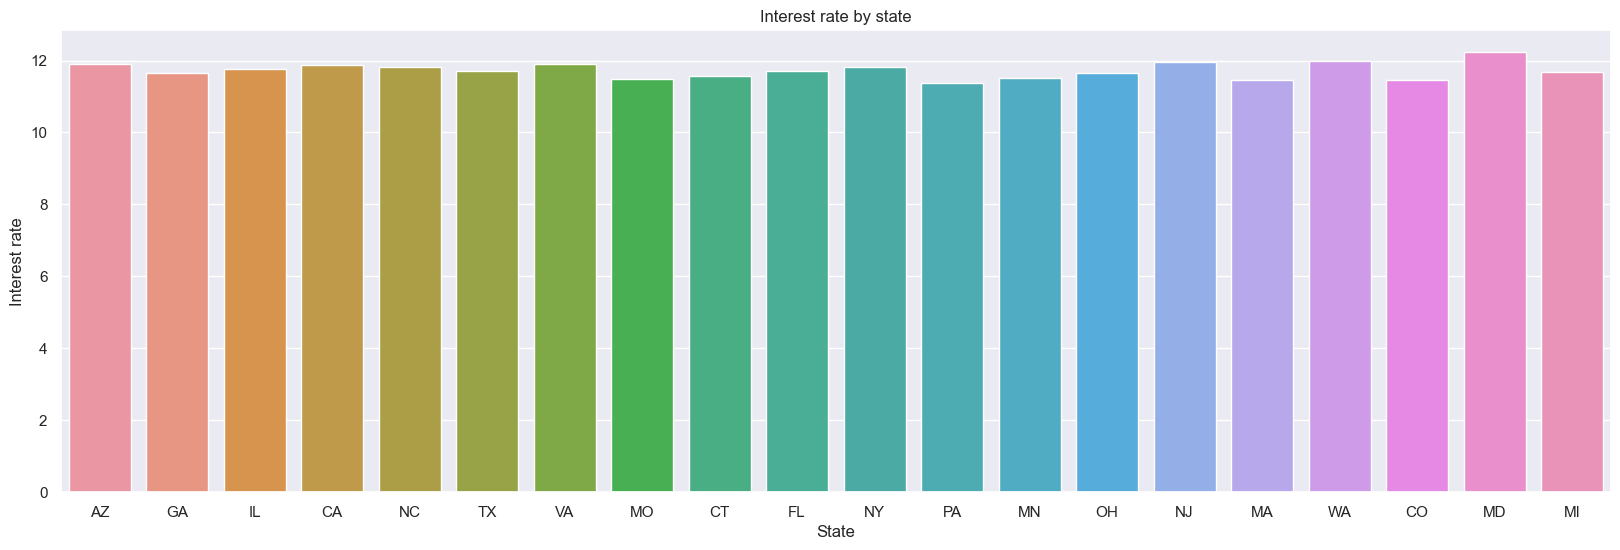

In [1797]:
# interest rate by state
plt.figure(figsize=(20, 6))

loans_per_State = loans[['addr_state', 'int_rate']].copy()

# ignore states with less than 500 loans
loans_per_State = loans_per_State.groupby(['addr_state']).filter(lambda x: len(x) > 500)

sns.barplot(x='addr_state', y='int_rate', data=loans_per_State, errorbar=None)

plt.title('Interest rate by state')
plt.xlabel('State')
plt.ylabel('Interest rate')
plt.show()

Check comments in the above & below-to-below cell and correct the values 

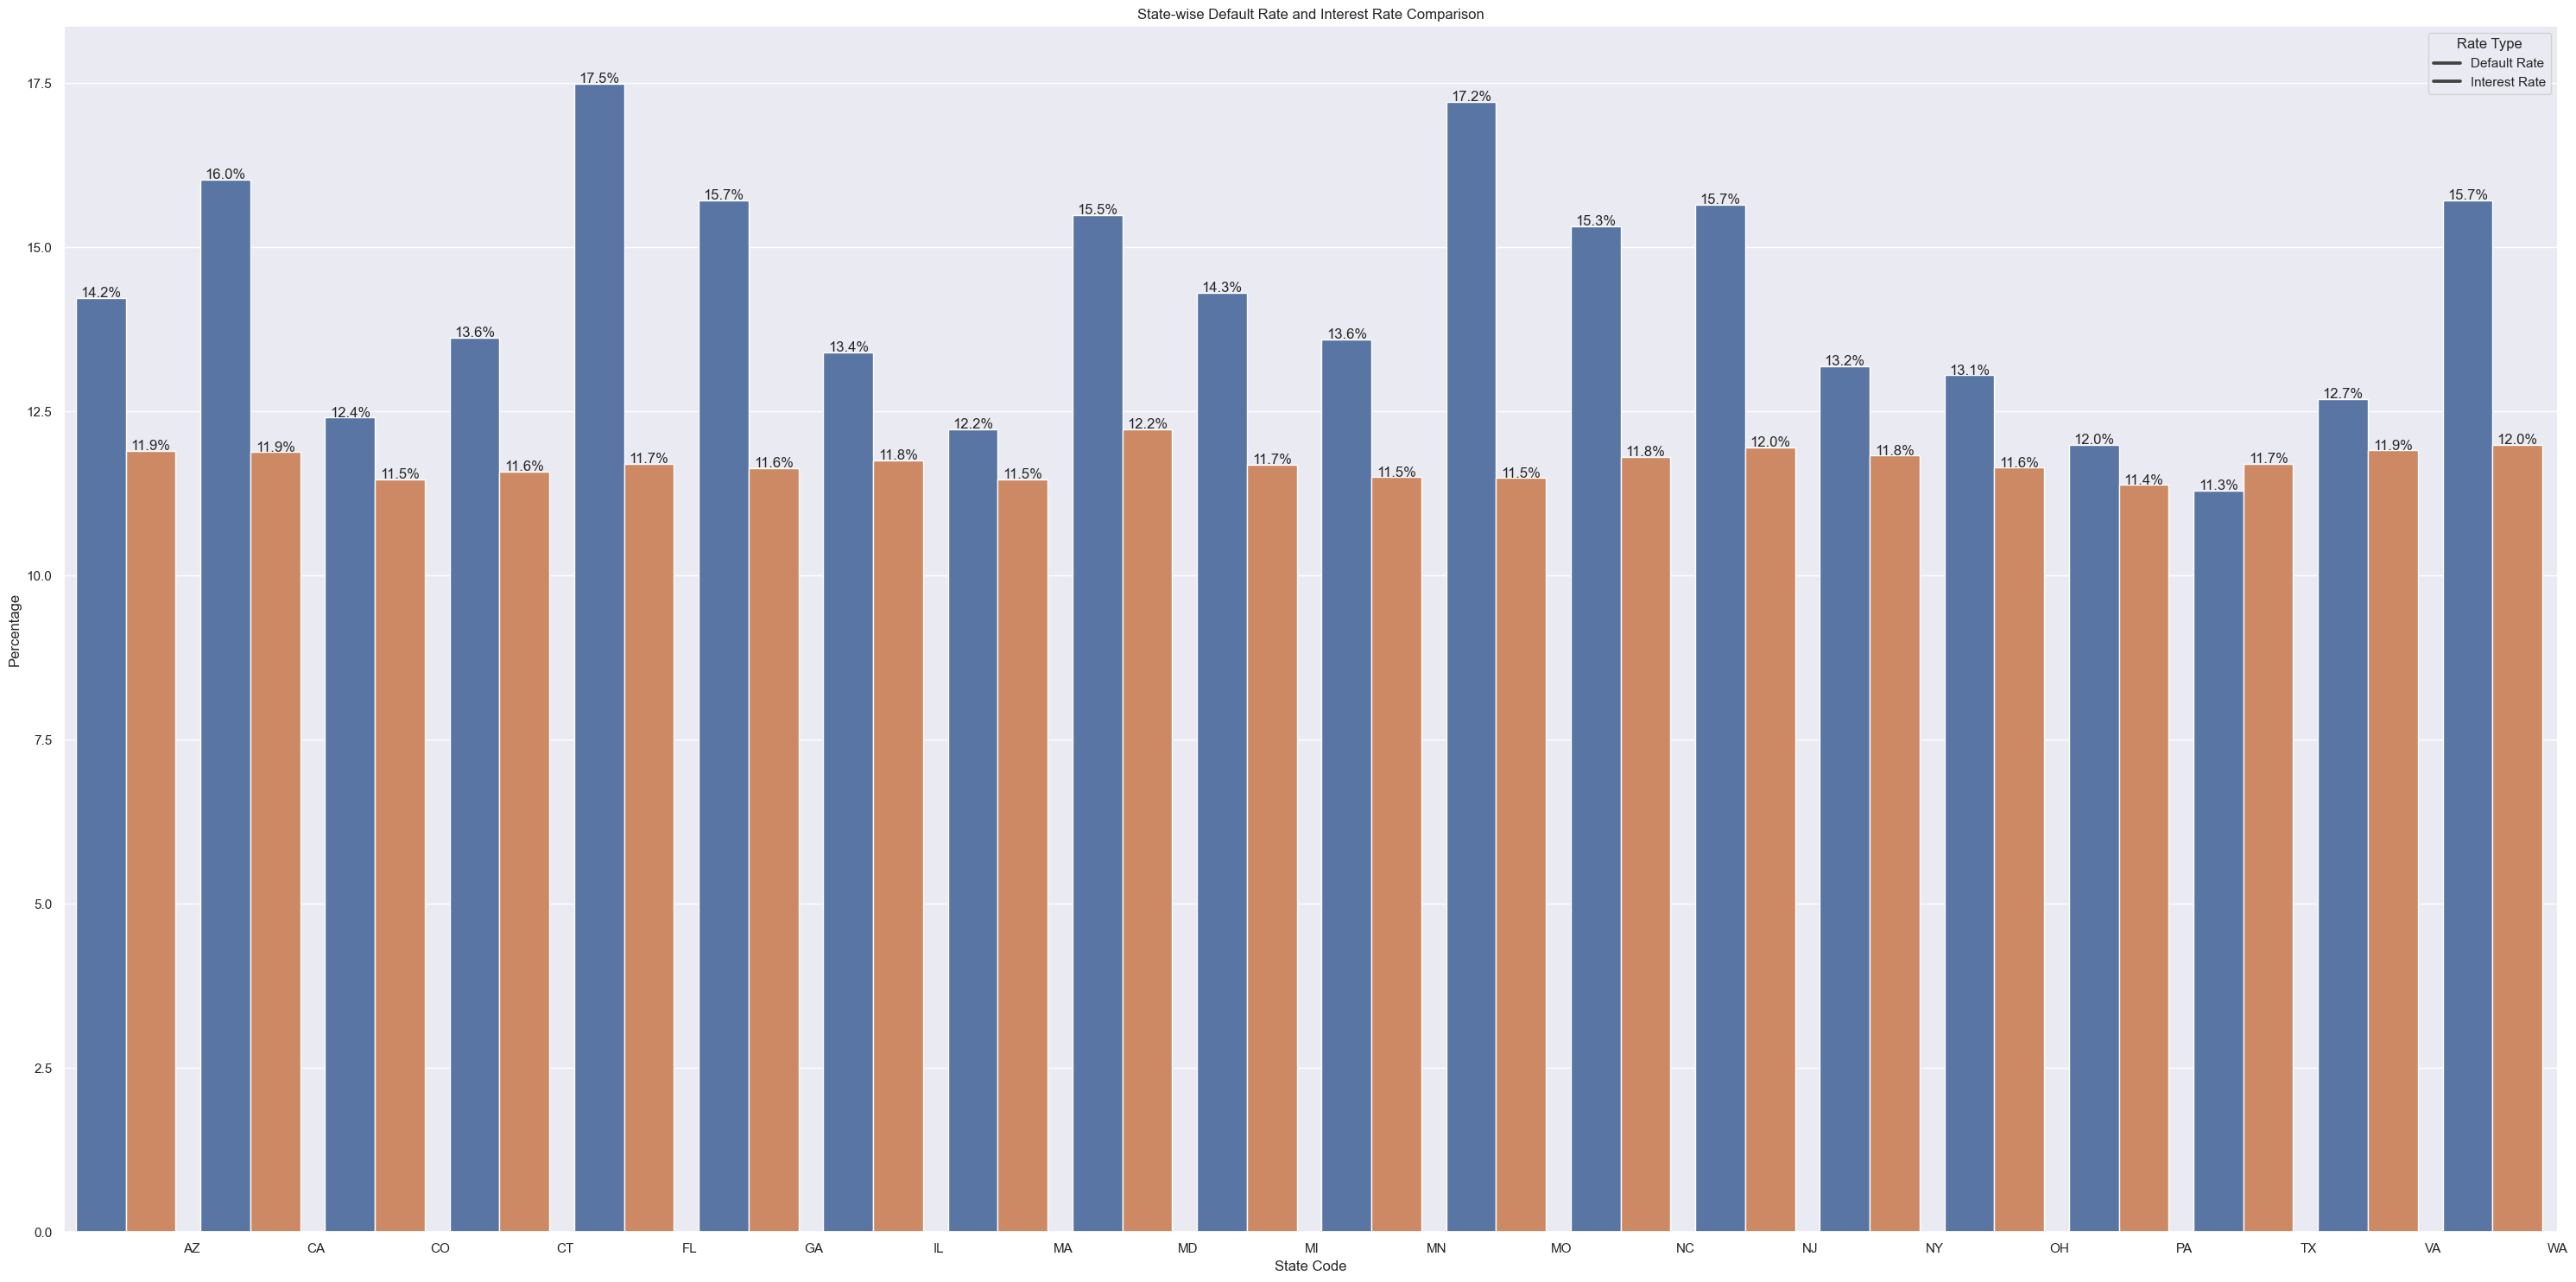

In [1796]:
plt.figure(figsize=(30, 15))

avg_int_rate_per_State = loans[['addr_state', 'int_rate']].copy()

# ignore states with less than 500 loans
avg_int_rate_per_State = avg_int_rate_per_State.groupby(['addr_state']).filter(lambda x: len(x) > 500)

avg_int_rate_per_State = avg_int_rate_per_State.groupby(by='addr_state').mean()


avg_default_rate_per_State = loans[['addr_state', 'default']].copy()

# ignore states with less than 100 loans
avg_default_rate_per_State = avg_default_rate_per_State.groupby(['addr_state']).filter(lambda x: len(x) > 500)

avg_default_rate_per_State = avg_default_rate_per_State.groupby(by='addr_state').mean()

avg_rate_data_per_State = avg_default_rate_per_State.merge(avg_int_rate_per_State, on='addr_state')

new_data = avg_rate_data_per_State.stack().reset_index()
new_data.columns = ['State Code', 'Rate Type', 'Percentage']
new_data

ax = sns.barplot(x='State Code', y='Percentage', hue='Rate Type', data=new_data)


# Add percentages on each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.01,
            '{:.1%}'.format(height/100),
            ha="center")

# Set spacing between each double bar plot
bar_width = 0.35
total_bars = len(new_data['State Code'].unique())
ax.set_xticks([x + bar_width / 2 + bar_width for x in range(total_bars)])
ax.set_xticklabels(new_data['State Code'].unique())

plt.xlabel('State Code')
plt.ylabel('Percentage')
plt.title('State-wise Default Rate and Interest Rate Comparison')

plt.xticks(rotation=0)

plt.legend(title='Rate Type', loc='upper right', labels=['Default Rate', 'Interest Rate'])


plt.tight_layout()
plt.show()

### Public records (good impact)

Loans given to borrowers with public records have a much higher default rate.

In [ ]:
print(loans['pub_rec_bankruptcies'].value_counts())

# ignore 2 public recorded bankruptcies as they are very few
loans = loans[loans['pub_rec_bankruptcies'] != 2]

# draw default by pub_rec_bankruptcies
plt.figure(figsize=(20, 6))
default_rate = loans.groupby(['pub_rec_bankruptcies']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='pub_rec_bankruptcies', y='default', data=default_rate)
plt.title('Default rate by public recorded bankruptcies')
plt.xlabel('public recorded bankruptcies')
plt.ylabel('Default rate')
plt.show()


### Interest rate (not relevant)

Interest rates are abviously higher for higher risk loans. this is correlated and driven by grade and subgrade of the loan, and is not a relevant driving factor, as it is assigned by lending club itself based on the credit score of the borrower.

In [ ]:
# draw default by binned interest rate
plt.figure(figsize=(20, 6))
default_rate_interest = loans[['int_rate', 'default']].copy()
# bin interest rate using intervals of 1% on column 'int_rate'
bin_edges = range(int(default_rate_interest['int_rate'].min()), int(default_rate_interest['int_rate'].max() + 1), 1)
default_rate_interest['int_rate_bin'] = pd.cut(default_rate_interest['int_rate'], bins=bin_edges, include_lowest=True, right=False)
default_rate_interest = default_rate_interest.groupby(['int_rate_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='int_rate_bin', y='default', data=default_rate_interest)
plt.title('Default rate by interest rate')
plt.xlabel('Interest rate')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_interest['int_rate_bin']])
plt.ylabel('Default rate')
plt.show()

### Loan amount (good impact)

Default rate is higher for higher loan amounts.

In [ ]:
# plot number of loans by binned loan amount
plt.figure(figsize=(20, 6))
default_rate_loan_amount = loans[['loan_amnt', 'default']].copy()
# bin loan amount using intervals of 2000 on column 'loan_amnt'
bin_size = 5000
bin_edges = range(int(default_rate_loan_amount['loan_amnt'].min()), int(default_rate_loan_amount['loan_amnt'].max() + bin_size), bin_size)
default_rate_loan_amount['loan_amnt_bin'] = pd.cut(default_rate_loan_amount['loan_amnt'], bins=bin_edges, include_lowest=True, right=False)
default_rate_loan_amount = default_rate_loan_amount.groupby(['loan_amnt_bin']).agg({'default': 'count'}).reset_index()

bar_plot = sns.barplot(x='loan_amnt_bin', y='default', data=default_rate_loan_amount)

# Get the minimum and maximum values from your data
min_val = default_rate_loan_amount['default'].min()
max_val = default_rate_loan_amount['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Number of loans by loan amount')
plt.xlabel('Loan amount')
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_loan_amount['loan_amnt_bin']], rotation=45)
plt.ylabel('Number of loans')
plt.show()

In [ ]:
# plot default rate by binned loan amount
plt.figure(figsize=(20, 6))
default_rate_loan_amount = loans[['loan_amnt', 'default']].copy()
# bin loan amount using intervals of 2000 on column 'loan_amnt'
bin_size = 5000
bin_edges = range(int(default_rate_loan_amount['loan_amnt'].min()), int(default_rate_loan_amount['loan_amnt'].max() + bin_size), bin_size)

default_rate_loan_amount['loan_amnt_bin'] = pd.cut(default_rate_loan_amount['loan_amnt'], bins=bin_edges, include_lowest=True, right=False)
default_rate_loan_amount = default_rate_loan_amount.groupby(['loan_amnt_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='loan_amnt_bin', y='default', data=default_rate_loan_amount)

# Get the minimum and maximum values from your data
min_val = default_rate_loan_amount['default'].min()
max_val = default_rate_loan_amount['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by loan amount')
plt.xlabel('Loan amount')
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_loan_amount['loan_amnt_bin']], rotation=45)
plt.ylabel('Default rate')
plt.show()

### Debt to income ratio (good impact)

Default rate is higher for higher debt to income ratio. debt to income ratio is the ratio of the borrower's total monthly debt payments to the borrower's monthly income.

Higher the Debt to income ratio indicates the borrower is handling more debt than he can afford to pay.

In [ ]:
# plot default rate by dti
plt.figure(figsize=(20, 6))
default_rate_dti = loans[['dti', 'default']].copy()

# bin dti using intervals of 5 on column 'dti'
bin_edges = range(int(default_rate_dti['dti'].min()), int(default_rate_dti['dti'].max() + 2), 2)
default_rate_dti['dti_bin'] = pd.cut(default_rate_dti['dti'], bins=bin_edges, include_lowest=True, right=False)
default_rate_dti = default_rate_dti.groupby(['dti_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='dti_bin', y='default', data=default_rate_dti)

# Get the minimum and maximum values from your data
min_val = default_rate_dti['default'].min()
max_val = default_rate_dti['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by debt to income ratio')
plt.xlabel('Debt to income ratio')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_dti['dti_bin']])
plt.ylabel('Default rate')
plt.show()

### Employment length of the borrower (no impact)

Employment length has no impact on default rate.

In [ ]:
# plot default rate by emp_length
plt.figure(figsize=(20, 6))
default_rate_emp_length = loans[['emp_length', 'default']].copy()
default_rate_emp_length = default_rate_emp_length.groupby(['emp_length']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='emp_length', y='default', data=default_rate_emp_length)
plt.title('Default rate by employment length')
plt.xlabel('Employment length')
plt.ylabel('Default rate')
plt.show()

### Verification status of borrower (no impact)

Verification status of the lendee does not seem to have any impact on the default rate.

In [ ]:
# plot default rate by verification_status
plt.figure(figsize=(20, 6))
default_rate_verification_status = loans[['verification_status', 'default']].copy()
default_rate_verification_status = default_rate_verification_status.groupby(['verification_status']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='verification_status', y='default', data=default_rate_verification_status)
plt.title('Default rate by verification status')
plt.xlabel('Verification status')
plt.ylabel('Default rate')
plt.show()

### Previously closed credit lines (good impact)

Default rate reduces with increase in closed credit lines, meaning that people with more closed credit lines are more likely to pay back the loan due to their richer credit history

In [ ]:
# create new column closed_acc
loans['closed_acc'] = loans['total_acc'] - loans['open_acc']

# plot default rate by binned closed credit lines
plt.figure(figsize=(20, 6))
default_rate_closed_acc = loans[['closed_acc', 'default']].copy()
# remove outliers for closed_acc
default_rate_closed_acc = default_rate_closed_acc[default_rate_closed_acc['closed_acc'] < 50]
# bin closed_acc using intervals of 5 on column 'closed_acc'
bin_size = 5
bin_edges = range(int(default_rate_closed_acc['closed_acc'].min()), int(default_rate_closed_acc['closed_acc'].max() + bin_size), bin_size)
default_rate_closed_acc['closed_acc_bin'] = pd.cut(default_rate_closed_acc['closed_acc'], bins=bin_edges, include_lowest=True, right=False)
default_rate_closed_acc = default_rate_closed_acc.groupby(['closed_acc_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='closed_acc_bin', y='default', data=default_rate_closed_acc)

# Get the minimum and maximum values from your data
min_val = default_rate_closed_acc['default'].min()
max_val = default_rate_closed_acc['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by closed credit lines')
plt.xlabel('Closed credit lines')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_closed_acc['closed_acc_bin']])
plt.ylabel('Default rate')
plt.show()

### Revolving credit utilization (huge impact)

Default rate increases with increase in revolving credit utilization, meaning that people with higher credit utilization are more likely to default on the loan as they have much less margin for error

Number of loans is almost evenly distributed across the credit utilization range which means that lending club is not taking this into account while giving loans.

In [ ]:
# plot default rate by binned revol_util
plt.figure(figsize=(20, 6))
default_rate_revol_util = loans[['revol_util', 'default']].copy()

# bin revol_util using intervals of 10 on column 'revol_util'
bin_size = 10
bin_edges = range(int(default_rate_revol_util['revol_util'].min()), int(default_rate_revol_util['revol_util'].max() + bin_size), bin_size)
default_rate_revol_util['revol_util_bin'] = pd.cut(default_rate_revol_util['revol_util'], bins=bin_edges, include_lowest=True, right=False)
default_rate_revol_util = default_rate_revol_util.groupby(['revol_util_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='revol_util_bin', y='default', data=default_rate_revol_util)
plt.title('Default rate by revolving utilization')
plt.xlabel('Revolving utilization')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_revol_util['revol_util_bin']])
plt.ylabel('Default rate')
plt.show()

In [ ]:
# plot number of loans by revol_util
plt.figure(figsize=(20, 6))
default_rate_revol_util = loans[['revol_util', 'default']].copy()
# remove outliers for revol_util
default_rate_revol_util = default_rate_revol_util[default_rate_revol_util['revol_util'] < 100]
# bin revol_util using intervals of 10 on column 'revol_util'
bin_size = 10
bin_edges = range(int(default_rate_revol_util['revol_util'].min()), int(default_rate_revol_util['revol_util'].max() + bin_size), bin_size)
default_rate_revol_util['revol_util_bin'] = pd.cut(default_rate_revol_util['revol_util'], bins=bin_edges, include_lowest=True, right=False)
default_rate_revol_util = default_rate_revol_util.groupby(['revol_util_bin']).agg({'default': 'count'}).reset_index()

bar_plot = sns.barplot(x='revol_util_bin', y='default', data=default_rate_revol_util)
plt.title('Number of loans by revolving utilization')
plt.xlabel('Revolving utilization')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_revol_util['revol_util_bin']])
plt.ylabel('Number of loans')
plt.show()

### Number of inquiries (good impact)

Default rate is much higher for people with more inquiries, this could be because they are looking for more loans and worsening their financial situation

In [ ]:
# plot default rate by inq_last_6mths
plt.figure(figsize=(20, 6))
default_rate_inq_last_6mths = loans[['inq_last_6mths', 'default']].copy()

print(loans['inq_last_6mths'].value_counts())

# remove outliers for inq_last_6mths, for values greater than or equal to 4 as they are very few
default_rate_inq_last_6mths = default_rate_inq_last_6mths[default_rate_inq_last_6mths['inq_last_6mths'] < 4]

default_rate_inq_last_6mths = default_rate_inq_last_6mths.groupby(['inq_last_6mths']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='inq_last_6mths', y='default', data=default_rate_inq_last_6mths)

# Get the minimum and maximum values from your data
min_val = default_rate_inq_last_6mths['default'].min()
max_val = default_rate_inq_last_6mths['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by inquiries in last 6 months')
plt.xlabel('Inquiries in last 6 months')
plt.ylabel('Default rate')
plt.show()


### Delinquencies for past 2 years (good impact)

Default rate increases with increase in delinquencies for past 2 years, meaning that people with more delinquencies are more likely to default on the loan as they have a history of not paying back their loans

In [ ]:
# plot default rate by delinq_2yrs
plt.figure(figsize=(20, 6))
default_rate_delinq_2yrs = loans[['delinq_2yrs', 'default']].copy()

print(default_rate_delinq_2yrs['delinq_2yrs'].value_counts())

# for values greater than or equal to 3 as they are very few records, so remove them
default_rate_delinq_2yrs = default_rate_delinq_2yrs[default_rate_delinq_2yrs['delinq_2yrs'] < 3]

default_rate_delinq_2yrs = default_rate_delinq_2yrs.groupby(['delinq_2yrs']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='delinq_2yrs', y='default', data=default_rate_delinq_2yrs)

# Get the minimum and maximum values from your data
min_val = default_rate_delinq_2yrs['default'].min()
max_val = default_rate_delinq_2yrs['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by delinquencies in last 2 years')
plt.xlabel('Delinquencies in last 2 years')
plt.ylabel('Default rate')
plt.show()

In [ ]:
loans.info()

# Correlation Matrix

In [ ]:
#Finding correlation matric
corr_matrix = loans[[ 'default', 'loan_amnt', 'funded_amnt', 'int_rate', 'open_acc', 'installment', 'annual_inc', 'grade_num', 'term_num', 'emp_length', 'delinq_2yrs', 'pub_rec_bankruptcies', 'revol_util',  'dti']].corr()
plt.figure(figsize=(20,20))
#plotting correlatioon matric on a heat map
ax = sns.heatmap(corr_matrix, annot = True, cmap='Blues')
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)
plt.title("Correlation between Columns")
plt.show()

### Observations :
- Default rate is negatively correlated with annual income of the borrower
- Default rate is positively correlatd with interest rate, which means as the interest rate increases, default rate also increasee.
- Loan amount is negatively correlated with pub_rec_bankruptcies.
- Interest rate is negatively correlated to employement length
- Interest rate increases with increase in grade number i.e., it increases while one's grade moves from A to G
- Interest also increases with revol_util